# Load Libraries and Resources

In [1]:
library('readr')
library('blabr')
library('plyr')
library('dplyr')
library('ggplot2')
library('rjson')
library('parallel')
library("readxl")
library('dotwhisker')
library('broom')
library('lme4')
library('irr')
library('tuneR')
library('ggExtra')
library('brms')
library('ggstance')
source('PLEARN_analysis_helper.R')
source('texvars.R')
tvc = initialize_texvar_cache()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loading required package: lpSolve

Loading required package: Rcpp

Loading 'brms' package (version 2.17.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:lme4’:

    ngrps


The following object is masked from ‘package:stats’:

    ar



Attaching package: ‘ggstance’


The following objects are masked from ‘package:ggplot2’:

    geom_errorbarh, GeomErrorbarh




# Load Objects from Data Preparation

In [2]:
subject_info = readRDS(file='intermediate_data/subject_info.RData')

# Preprocess / Plot Production Data

In [3]:
p_coded = subset(rbind.fill(
    read.csv('productions_coded.csv', stringsAsFactors=F),
    read.csv('lookit_productions_coded.csv', stringsAsFactors=F)),
    !(itemId %in% c('p1','p2','p3','p4')))

p_coded$itemId = as.numeric(as.factor(as.character(p_coded$Lemma)))
print(names(p_coded))
print(nrow(p_coded))

[1] "child"                "itemId"               "Lemma"               
[4] "Singular.description" "Singular.Code"        "Plural.Description"  
[7] "Plural.Code"          "Comments"             "X"                   
[1] 2544


In [4]:
children = subset(subject_info, type == 'child')
p_coded_children = data.frame(id = unique(p_coded$child), has_production_data = TRUE)

In [5]:
children_w_production_data = merge(children, p_coded_children, all=T)
subset(children_w_production_data, is.na(has_production_data))$id

[1] "8d9a77c4-d67b-4e42-8b11-21ab38907c6b"
[2] "pl00"                                
[3] "pl120"                               
[4] "pl38"                                
[5] "pl53"                                
[6] "pl56"                                
[7] "pl58"                                
[8] "pl92"

# Code the Production Data

In [6]:
numTrialsPerChild = aggregate(itemId ~ child, p_coded, length)
numTrialsPerChild = numTrialsPerChild[order(numTrialsPerChild$itemId, decreasing=T),]
if (nrow(subset(numTrialsPerChild, itemId != 16)) > 0){
    stop('Coded child data is missing trials')
}

In [7]:
num_production_items = length(unique(p_coded$itemId)) #16 test x 2 + 4 shared practice
if (num_production_items != 32){
    stop('There should be 32 test production items')
}

In [8]:
# Look for weird things among the lemmas in case the above throw an error
unique(p_coded$Lemma)

[1] "pog"    "rabbit" "nug"    "star"   "tep"    "fip"    "pig"    "truck" 
 [9] "gub"    "fork"   "cup"    "gop"    "tig"    "cow"    "nep"    "cat"   
[17] "bug"    "mip"    "deg"    "frog"   "nop"    "boat"   "kib"    "teb"   
[25] "plate"  "ant"    "pib"    "dup"    "duck"   "spoon"  "gip"    "egg"

In [9]:
codebook = c(
    'No data (0)',
    'No verbal response (1)',
    'Not identifiable/babble (2)',
    'Other word (not noun) (3)',
    'Noun from context (4)',
    'Singular form (5)',    
    'Non-conventional plural form (6)',
    'Plural form, approximate articulation (7)',
    'Plural form, adult-like articulation (8)' 
)

codes = data.frame(code = seq(0,8), description = codebook)
codes$description = factor(codes$description, levels = codebook)

In [10]:
pt_ds = read.csv('../PLEARN_experiments/plearn_productiveTask_datasource.csv')
p_coded = merge(p_coded, pt_ds, by.x='Lemma', by.y='s_form')
nrow(p_coded)

[1] 2544

In [11]:
s_codes = aggregate(itemId ~ Singular.Code + child, p_coded, length)
names(s_codes) = c('code', 'child', 'count')
s_codes = merge(s_codes, codes, all = T)
s_codes$s_pl ='singular'
singulars_without_codes = subset(s_codes, code == '')
if (nrow(singulars_without_codes) > 0){
    print(singulars_without_codes)
    stop('Some singular trials lack codes')
}

In [12]:
p_codes = aggregate(itemId ~ Plural.Code + child, p_coded, length)
names(p_codes) = c('code', 'child','count')
p_codes = merge(p_codes, codes, all = T)
p_codes$s_pl = 'plural'
plurals_without_codes = subset(p_codes, code == '')
if (nrow(plurals_without_codes) > 0){
    print(plurals_without_codes)
    stop('Some plural trials lack codes')
}

In [13]:
code_counts = rbind.fill(s_codes, p_codes)
code_counts$s_pl = factor(code_counts$s_pl, levels =c('singular','plural'))
head(code_counts)

,code,child,count,description,s_pl
,<chr>,<chr>,<int>,<fct>,<fct>
1,0,pl154,6,No data (0),singular
2,0,pl127,1,No data (0),singular
3,0,1e04539d-c09d-4f71-96a4-5e01bb073d67,8,No data (0),singular
4,0,pl01,1,No data (0),singular
5,0,765d8cc5-efaf-4599-aa55-c48e43f46dc5,1,No data (0),singular
6,0,pl87,5,No data (0),singular


In [14]:
excluded_storybook_trials = subset(code_counts, description == 'No data (0)')
numStorybookTrialsExcluded = sum(excluded_storybook_trials$count)
print(numStorybookTrialsExcluded)
numChildrenWithTrialsExcludedFromStorybook =length(unique(excluded_storybook_trials$child))
print(numChildrenWithTrialsExcludedFromStorybook)
tvc = update_texvar_cache(tvc, 'numStorybookTrialsExcluded', numStorybookTrialsExcluded)
tvc = update_texvar_cache(tvc, 'numChildrenWithTrialsExcludedFromStorybook', numChildrenWithTrialsExcludedFromStorybook)

[1] 67
[1] 21


# Inter-Annotator Agreement on the Storybook Task

In [15]:
unique(p_coded$Plural.Code)

[1] "1" "6" "5" "8" "3" "0" "7" "4" "2"

In [16]:
p_coded$Singular.Code.Downsampled = sapply(as.character(p_coded$Singular.Code), function(x){
    remap[[x]]
})
p_coded$Plural.Code.Downsampled = unlist(sapply(as.character(p_coded$Plural.Code), function(x){
    remap[[x]]
}))

In [17]:
p_coded_check = subset(read.csv('productions_coded_check.csv', stringsAsFactors=F), !(child %in% c(
'oddParticipant', 'evenParticipant')) & !(itemId %in% c('p1','p2','p3','p4'))) 
p_coded_check$X = NULL
remap_check = list()
remap_check[['No Data']] = 'No Data'
remap_check[['singular']] = 'Singular'
remap_check[['no response / non-relevant']] = 'No Response / Not Relevant'
remap_check[['non-conventional plural']] = 'Non-Conventional Plural'
remap_check[['plural']] = 'Plural'
remap_check[['']] = ''

p_coded_check$Singular.Code = sapply(as.character(p_coded_check$Singular.Code),
    function(x){
    remap_check[[x]]
})
p_coded_check$Plural.Code = sapply(as.character(p_coded_check$Plural.Code), function(x){
    remap_check[[x]]
})
nrow(p_coded_check)

[1] 400

In [18]:
p_coded_both = as.data.frame(merge(
    p_coded_check, p_coded[,c('child','Lemma','Singular.Code.Downsampled',
                                'Plural.Code.Downsampled')]),
    by = c('child','Lemma'))
p_coded_both$Singular.Code.Downsampled = as.character(p_coded_both$Singular.Code.Downsampled)

In [19]:
nrow(subset(p_coded, child %in% unique(p_coded_check$child))) # expect 400

[1] 400

In [20]:
length(unique(p_coded_both$child))
nrow(p_coded_both)

[1] 25

[1] 400

In [21]:
sing_kappa = kappa2(p_coded_both[,c('Singular.Code','Singular.Code.Downsampled')])
sing_kappa

 Cohen's Kappa for 2 Raters (Weights: unweighted)

 Subjects = 400 
   Raters = 2 
    Kappa = 0.866 

        z = 18.1 
  p-value = 0 

In [22]:
pl_kappa = kappa2(p_coded_both[,c('Plural.Code','Plural.Code.Downsampled')])
pl_kappa

 Cohen's Kappa for 2 Raters (Weights: unweighted)

 Subjects = 400 
   Raters = 2 
    Kappa = 0.8 

        z = 25.3 
  p-value = 0 

In [23]:
tvc = update_texvar_cache(tvc, 'kappaPlurals', pl_kappa$value)
tvc = update_texvar_cache(tvc, 'kappaSingulars', sing_kappa$value)


Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.”


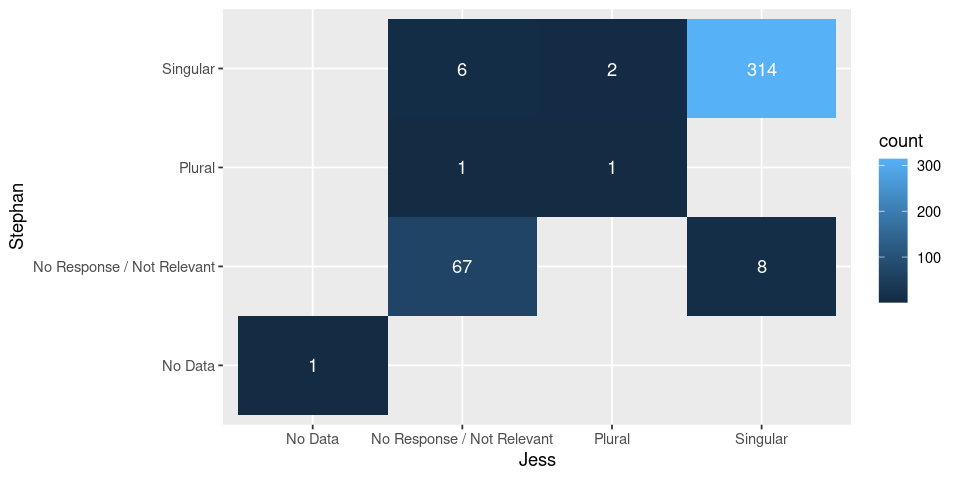

In [24]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot(p_coded_both, aes(x=Singular.Code, y=Singular.Code.Downsampled)) + stat_bin2d(
) + stat_bin2d(geom = "text", aes(label = ..count..), binwidth = 1, color='white'
)  + ylab('Stephan') + xlab('Jess')

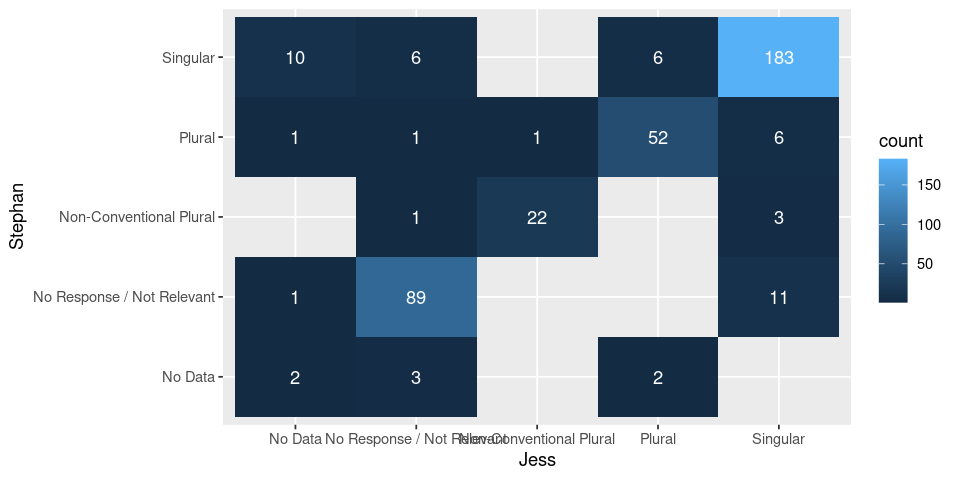

In [25]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot(p_coded_both, aes(x=Plural.Code, y=Plural.Code.Downsampled)) + stat_bin2d(
) + stat_bin2d(geom = "text", aes(label = ..count..), binwidth = 1, color='white'
)  + ylab('Stephan') + xlab('Jess')

# Compute Production Scores

In [26]:
# note that both of these are subset to singular succeses
computeProductionScores = function(codes, method = 'narrow'){    
    if (method == 'narrow'){
        # if they marked the plural in some way,was it adult-like? (i.e. the question in
        # Clark and Nikitina (2009))
        sum(codes %in% c(7,8)) / sum(codes %in% seq(6,8))
        # this is NA if they don't produce anything in categories 6-8, which is a relatively common situation
    } else if (method == 'broad') {
        # did they mark the plural?
        sum(codes %in% c(7,8)) / sum(codes %in% seq(2,8))
    }
}

In [27]:
narrow_production_scores = aggregate(Plural.Code ~ child, subset(p_coded, Singular.Code == 5), computeProductionScores)
names(narrow_production_scores) = c('participant_name', 'narrow_score')
broad_production_scores = aggregate(Plural.Code ~ child, subset(p_coded, Singular.Code == 5), function(x){
    computeProductionScores(x,'broad')})
names(broad_production_scores) = c('participant_name','broad_score')

# Associate Production Scores with Subject Records

In [28]:
# add the production scores to subject info
subject_info_with_broad_scores = merge(merge(subject_info, broad_production_scores, all=T), 
                     narrow_production_scores, all=T)

In [29]:
# find particiapnts who are lost
setdiff(subset(subject_info_with_broad_scores, type == 'child' & expt_version %in% c('scene','redblue','agreement','agreement-lookit'))$participant_name,
    subset(broad_production_scores, !is.nan(broad_score))$participant_name)


[1] "765d8cc5-efaf-4599-aa55-c48e43f46dc5"
 [2] "8d9a77c4-d67b-4e42-8b11-21ab38907c6b"
 [3] "pl00"                                
 [4] "pl11"                                
 [5] "pl120"                               
 [6] "pl151"                               
 [7] "pl38"                                
 [8] "pl53"                                
 [9] "pl56"                                
[10] "pl58"                                
[11] "pl72"                                
[12] "pl92"

hashed ids are lookit tasks without storybook tasks
ppl00, dosn't have any storybook task
pl151, pl38, pl53, pl56, pl58, pl92  fussed out
pl11, pl120 don't have any singulars, can't compute broad score
pl72 was silent for all plural trials 

# Test for Normality

In [30]:
names(subject_info_with_broad_scores)

[1] "participant_name"    "narrow_score"        "broad_score"        
 [4] "id"                  "include_eyetracking" "include_storybook"  
 [7] "filename"            "age_in_days"         "gender"             
[10] "type"                "expt_version"        "group"              
[13] "order"               "comment"             "main_coder"         
[16] "main_validated"      "double_coder"        "double_validated"   
[19] "comments"            "trial_order"         "age_in_months"      
[22] "ran_participant"     "child_in_study"      "fam_pl"             
[25] "nov_pl"              "total_pl"

In [31]:
expt_versions = c('scene','redblue','agreement')

In [32]:
for (this_expt_version in expt_versions){
    print(shapiro.test(
        subset(subject_info_with_broad_scores, 
               child_in_study & expt_version == this_expt_version)$broad_score
    ))
}


	Shapiro-Wilk normality test

data:  subset(subject_info_with_broad_scores, child_in_study & expt_version == this_expt_version)$broad_score
W = 0.83437, p-value = 8.483e-05


	Shapiro-Wilk normality test

data:  subset(subject_info_with_broad_scores, child_in_study & expt_version == this_expt_version)$broad_score
W = 0.74787, p-value = 8.33e-07


	Shapiro-Wilk normality test

data:  subset(subject_info_with_broad_scores, child_in_study & expt_version == this_expt_version)$broad_score
W = 0.70065, p-value = 7.704e-08



Production scores are not normally distributed

# Test for Combining Production Experiments

In [33]:
# can we combine the production data across all of the different versions


rank_sum_test_for_combining_production  = mat.or.vec(length(expt_versions), length(expt_versions))
rank_sum_test_for_combining_production = rank_sum_test_for_combining_production +1

for (i in 1:length(expt_versions)){
    for (j in c(1:i)){
        rank_sum_test_for_combining_production[i,j] = wilcox.test(subset(subject_info_with_broad_scores, child_in_study & expt_version == expt_versions[i])$broad_score,
             subset(subject_info_with_broad_scores, child_in_study & expt_version == expt_versions[j])$broad_score)$p.value
        }
}
    
rank_sum_test_for_combining_production        

Warning message in wilcox.test.default(subset(subject_info_with_broad_scores, child_in_study & :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(subset(subject_info_with_broad_scores, child_in_study & :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(subset(subject_info_with_broad_scores, child_in_study & :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(subset(subject_info_with_broad_scores, child_in_study & :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(subset(subject_info_with_broad_scores, child_in_study & :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(subset(subject_info_with_broad_scores, child_in_study & :
“cannot compute exact p-value with ties”


1.0000000,1.0000000,1
0.1915258,1.0000000,1
0.2367752,0.7897766,1


# Trial Level Regression Model for Production

In [34]:
p_coded = merge(p_coded, subject_info[,c('participant_name','age_in_months','include_storybook')], by.x='child',
     by.y='participant_name')

In [35]:
# downsampling process from the original code
p_coded$s_success = NA 
p_coded$s_success[p_coded$Singular.Code %in% c(5)] = 1
p_coded$s_success[p_coded$Singular.Code %in% seq(1,4)] = 0
p_coded$pl_success = NA 
p_coded$pl_success[p_coded$Plural.Code %in% c(7,8)] = 1
p_coded$pl_success[p_coded$Plural.Code %in% seq(1,6)] = 0
p_coded$age_in_months_c = p_coded$age_in_months - 30

In [36]:
numTrialsInSingularLM = nrow(p_coded)
tvc = update_texvar_cache(tvc, 'numTrialsInSingularLM', numTrialsInSingularLM)

## Singular Production

In [37]:
singular_lm_data = p_coded
singular_lm_data$novelty = binarize(singular_lm_data$novelty,c('familiar','novel'))
singular_lm_data$voicing = binarize(singular_lm_data$voicing,c('voiceless','voiced'))
singular_lm_data$animacyStatus = binarize(singular_lm_data$animacy,c('inanimate','animate'))

[1] "familiar" "novel"   
[1] "voiceless" "voiced"   
[1] "inanimate" "animate"  


In [38]:
head(singular_lm_data[,c('novelty','voicing','animacyStatus','age_in_months_c')])

,novelty,voicing,animacyStatus,age_in_months_c
,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,-1,-6
2,1,1,-1,-6
3,1,-1,-1,-6
4,-1,-1,1,-6
5,-1,1,1,-6
6,-1,-1,1,-6


In [39]:
# brms
singular_brm <- brm(s_success  ~ novelty * voicing * animacyStatus * age_in_months_c +    
    (novelty * voicing * animacyStatus | child) + (age_in_months_c|itemId), 
       data = singular_lm_data, family = bernoulli, chains = 4, cores = 16, backend = "cmdstanr", threads = threading(4))

#singular_lm
#https://www.jamesrrae.com/post/bayesian-logistic-regression-using-brms-part-1/
# age by  itemId slopes -- these are crazy noisy

Warning message:
“Rows containing NAs were excluded from the model.”
Start sampling



Running MCMC with 4 chains, at most 16 in parallel, with 4 thread(s) per chain...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 4 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 2 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 3 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 4 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 3 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 2 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 4 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 3 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 2 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 4 Iteration:  400 / 2000 [ 20

In [40]:
s_effects = as.data.frame(fixef(singular_brm))
subset(s_effects, s_effects$Q2.5 > 0 | s_effects$Q97.5 < 0)

,Estimate,Est.Error,Q2.5,Q97.5
,<dbl>,<dbl>,<dbl>,<dbl>
Intercept,4.1142278,0.41888598,3.37043625,4.9973897
age_in_months_c,0.2502886,0.09288912,0.06884522,0.4344613


In [41]:
numTrialsInPluralLM = nrow(subset(p_coded, Singular.Code ==5))
numTrialsInPluralLM
tvc = update_texvar_cache(tvc, 'numTrialsInPluralLM', numTrialsInPluralLM)

[1] 1927

In [42]:
plural_lm_data = subset(p_coded, Singular.Code ==5)
plural_lm_data$novelty = binarize(plural_lm_data$novelty,c('familiar','novel'))
plural_lm_data$voicing = binarize(plural_lm_data$voicing,c('voiceless','voiced'))
plural_lm_data$animacyStatus = binarize(plural_lm_data$animacy,c('inanimate','animate'))

[1] "familiar" "novel"   
[1] "voiceless" "voiced"   
[1] "inanimate" "animate"  


In [43]:
plural_brm <- brm(pl_success  ~ novelty * voicing * animacyStatus * age_in_months_c +
     (novelty * voicing * animacyStatus | child) +(age_in_months_c|itemId), 
       data = plural_lm_data, family = bernoulli, chains = 4, cores = 16, backend = "cmdstanr", threads = threading(4))


Warning message:
“Rows containing NAs were excluded from the model.”
Start sampling



Running MCMC with 4 chains, at most 16 in parallel, with 4 thread(s) per chain...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 4 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 2 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 3 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 4 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 2 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 3 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 4 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 2 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 3 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 4 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 2 Iteration:  400 / 2000 [ 20

In [44]:
storybook_lm_mixed_effects = rbind(prepModelForDWPlot(singular_brm) %>% mutate(model = "Singular"),
      prepModelForDWPlot(plural_brm) %>% mutate(model = "Plural")) 

In [45]:
keeps = unique(c(subset(storybook_lm_mixed_effects, sig)$term, subset(storybook_lm_mixed_effects, !interaction)$term))
storybook_lm_mixed_effects = subset(storybook_lm_mixed_effects, term %in% keeps)            
storybook_lm_mixed_effects

,Estimate,Est.Error,Q2.5,Q97.5,term,group,interaction,sig,model
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<lgl>,<chr>
Intercept,4.11422782,0.41888598,3.37043625,4.9973897,Intercept,fixed,FALSE,TRUE,Singular
novelty,-0.09443117,0.17623849,-0.43762367,0.2541852,novelty,fixed,FALSE,FALSE,Singular
voicing,-0.13805833,0.12709276,-0.38997427,0.1067174,voicing,fixed,FALSE,FALSE,Singular
animacyStatus,-0.14615277,0.13072124,-0.40639030,0.1175812,animacyStatus,fixed,FALSE,FALSE,Singular
age_in_months_c,0.25028855,0.09288912,0.06884522,0.4344613,age_in_months_c,fixed,FALSE,TRUE,Singular
Intercept1,-2.59229415,0.42428703,-3.46893450,-1.7958180,Intercept,fixed,FALSE,TRUE,Plural
novelty1,-0.62515956,0.18210495,-1.01519550,-0.3011143,novelty,fixed,FALSE,TRUE,Plural
voicing1,0.25793584,0.12274548,0.02006279,0.5039831,voicing,fixed,FALSE,TRUE,Plural
animacyStatus1,-0.08820880,0.13690710,-0.35090922,0.1858110,animacyStatus,fixed,FALSE,FALSE,Plural


In [46]:
relabel_storybook_terms = function(df, colname){
    remap = list()
    remap[['Intercept']] = 'Intercept'
    remap[['novelty']] = "Novelty\n(familiar vs. novel)"
    remap[['voicing']] = "Voicing\n(/s/ vs. /z/)"
    remap[['animacyStatus']] = "Animacy\n(inanimate vs. animate)"
    remap[['expt_versionredblue']] = "Simplified Experiment"
    remap[['age_in_months_c']] = "Child Age\n(in months, centered at 30)"
    remap[['novelty:age_in_months_c']] = "Novelty x Child Age"
    remap[['trial_index']] = 'Trial Order'

    
    df[[colname]] = sapply(df$term, function(x){remap[[x]]})
    df[[colname]] = factor(df[[colname]], levels = rev(c(
         'Intercept',
         "Novelty\n(familiar vs. novel)",
         "Voicing\n(/s/ vs. /z/)",
        "Animacy\n(inanimate vs. animate)",
         "Child Age\n(in months, centered at 30)",        
        "Trial Order"
     )))
    return(df)
}    
storybook_lm_mixed_effects = relabel_storybook_terms(storybook_lm_mixed_effects,'term')

In [47]:
storybook_lm_mixed_effects

,Estimate,Est.Error,Q2.5,Q97.5,term,group,interaction,sig,model
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<lgl>,<lgl>,<chr>
Intercept,4.11422782,0.41888598,3.37043625,4.9973897,Intercept,fixed,FALSE,TRUE,Singular
novelty,-0.09443117,0.17623849,-0.43762367,0.2541852,Novelty (familiar vs. novel),fixed,FALSE,FALSE,Singular
voicing,-0.13805833,0.12709276,-0.38997427,0.1067174,Voicing (/s/ vs. /z/),fixed,FALSE,FALSE,Singular
animacyStatus,-0.14615277,0.13072124,-0.40639030,0.1175812,Animacy (inanimate vs. animate),fixed,FALSE,FALSE,Singular
age_in_months_c,0.25028855,0.09288912,0.06884522,0.4344613,"Child Age (in months, centered at 30)",fixed,FALSE,TRUE,Singular
Intercept1,-2.59229415,0.42428703,-3.46893450,-1.7958180,Intercept,fixed,FALSE,TRUE,Plural
novelty1,-0.62515956,0.18210495,-1.01519550,-0.3011143,Novelty (familiar vs. novel),fixed,FALSE,TRUE,Plural
voicing1,0.25793584,0.12274548,0.02006279,0.5039831,Voicing (/s/ vs. /z/),fixed,FALSE,TRUE,Plural
animacyStatus1,-0.08820880,0.13690710,-0.35090922,0.1858110,Animacy (inanimate vs. animate),fixed,FALSE,FALSE,Plural


Warning message:
“Using the `size` aesthetic with geom_path was deprecated in ggplot2 3.4.0.
ℹ Please use the `linewidth` aesthetic instead.”


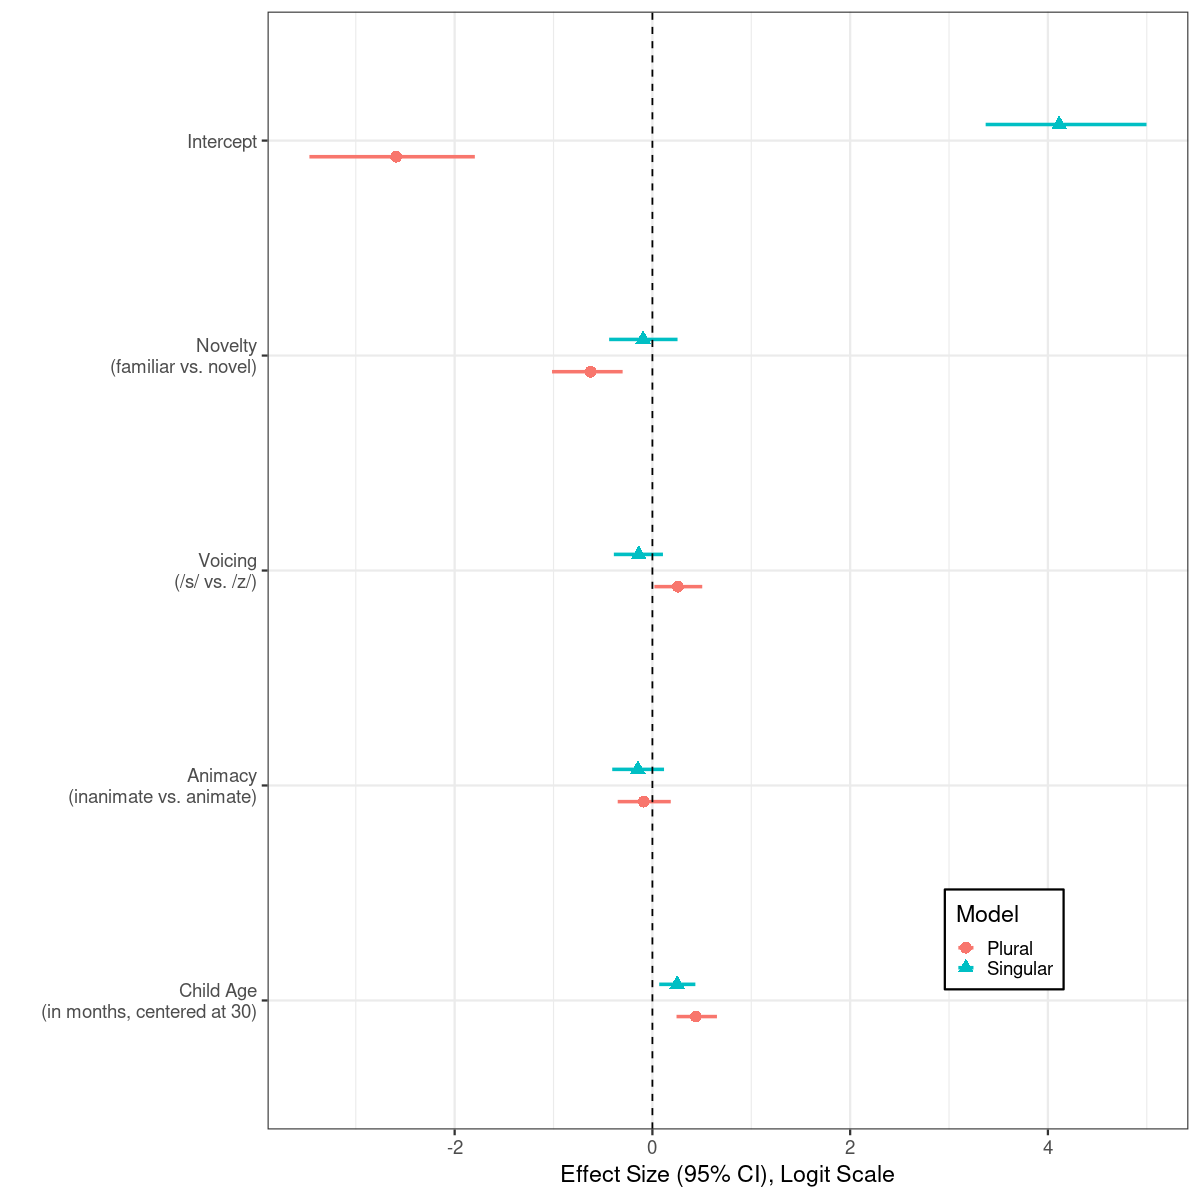

In [48]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot(as.data.frame(storybook_lm_mixed_effects) 
    ) + geom_errorbarh(aes(xmin=Q2.5, xmax=Q97.5,y=term, color=model), size=1,
        height=0, position=ggstance::position_dodgev(height=0.3)
    ) + geom_point(aes(x=Estimate,y=term, color=model, shape=model),
        position=ggstance::position_dodgev(height=0.3), size=3) + theme_bw(base_size=14
    ) + geom_vline(xintercept=0, lty=2) + xlab('Effect Size (95% CI), Logit Scale'
    ) + ylab('') + theme(
    legend.key.size = unit(.4, "cm"),
    legend.position = c(.8,.17), 
    legend.background = element_rect(fill="white", linetype="solid", 
                                  colour ="black")
    ) +  scale_shape_discrete(name = "Model") +  scale_color_discrete(name = "Model")

ggsave('figures/brms_storybook_lmem.pdf', width=8,height=3.2) 

In [49]:
tvc = get_texvar_from_beta(singular_brm, 'novelty','singularLMnovelty', tvc)
tvc = get_texvar_from_beta(plural_brm, 'novelty','pluralLMnovelty', tvc)
tvc = get_texvar_from_beta(plural_brm, 'voicing','pluralLMvoicing', tvc)
tvc = get_texvar_from_beta(singular_brm, 'age_in_months_c','singularLMage', tvc)
tvc = get_texvar_from_beta(plural_brm, 'age_in_months_c','pluralLMage', tvc)

In [50]:
tvc = get_texvar_from_beta(singular_brm, 'Intercept','singularLMIntercept', tvc)
tvc = get_texvar_from_beta(plural_brm, 'Intercept','pluralLMIntercept', tvc)

### Write out model results for the Supplementary Information

In [51]:
names(summary(singular_brm)$random)

[1] "child"  "itemId"

In [52]:
source('PLEARN_analysis_helper.R')
library('xtable')
library('stringr')
prepBRMStable(singular_brm, 'production_singular')
prepBRMStableRandom(singular_brm, 'production_singular', 'child')
prepBRMStableRandom(singular_brm, 'production_singular', 'itemId')
prepBRMStable(plural_brm, 'production_plural')
prepBRMStableRandom(plural_brm, 'production_plural', 'child')
prepBRMStableRandom(plural_brm, 'production_plural', 'itemId')

# Per-child variability test

In [53]:
m0 <- glmer(pl_success ~ 1 + (1|itemId), data=subset(plural_lm_data,age_in_months <= 28), family="binomial")
m1 <- glmer(pl_success ~ 1 + (1|child) + (1|itemId), data=subset(plural_lm_data,age_in_months <= 28), family="binomial")

boundary (singular) fit: see help('isSingular')



In [54]:
anova(m0,m1)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m0,2,734.3248,743.6383,-365.1624,730.3248,NA,NA,NA
m1,3,412.2089,426.1791,-203.1045,406.2089,324.1159,1,1.838172e-72


In [55]:
summary(m1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: pl_success ~ 1 + (1 | child) + (1 | itemId)
   Data: subset(plural_lm_data, age_in_months <= 28)

     AIC      BIC   logLik deviance df.resid 
   412.2    426.2   -203.1    406.2      775 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0365 -0.2218 -0.0613 -0.0519  4.3315 

Random effects:
 Groups Name        Variance Std.Dev.
 child  (Intercept) 17.1928  4.1464  
 itemId (Intercept)  0.3614  0.6011  
Number of obs: 778, groups:  child, 58; itemId, 32

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -4.788      1.162   -4.12 3.79e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [56]:
m0 <- glmer(s_success ~ 1 + (1|itemId), data=subset(singular_lm_data,age_in_months <= 28), family="binomial")
m1 <- glmer(s_success ~ 1 + (1|child) + (1|itemId), data=subset(singular_lm_data,age_in_months <= 28), family="binomial")
anova(m0,m1)

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m0,2,932.6193,942.3636,-464.3097,928.6193,NA,NA,NA
m1,3,597.1478,611.7642,-295.5739,591.1478,337.4715,1,2.267435e-75


In [57]:
summary(m1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: s_success ~ 1 + (1 | child) + (1 | itemId)
   Data: subset(singular_lm_data, age_in_months <= 28)

     AIC      BIC   logLik deviance df.resid 
   597.1    611.8   -295.6    591.1      962 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9693  0.0996  0.0996  0.2519  2.3084 

Random effects:
 Groups Name        Variance  Std.Dev. 
 child  (Intercept) 9.172e+00 3.029e+00
 itemId (Intercept) 7.009e-09 8.372e-05
Number of obs: 965, groups:  child, 61; itemId, 32

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   3.1706     0.5338    5.94 2.85e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
optimizer (Nelder_Mead) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')


In [58]:
### By Age Group
m1_young <- glmer(s_success ~ 1 + (1|child) + (1|itemId), data=subset(singular_lm_data,age_in_months <= 28), family="binomial")
summary(m1_young)
m1_middle <- glmer(s_success ~ 1 + (1|child) + (1|itemId), data=subset(singular_lm_data,age_in_months > 28 & age_in_months <= 32), family="binomial")
summary(m1_middle)
m1_old <- glmer(s_success ~ 1 + (1|child) + (1|itemId), data=subset(singular_lm_data,age_in_months > 32), family="binomial")
summary(m1_old)

boundary (singular) fit: see help('isSingular')



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: s_success ~ 1 + (1 | child) + (1 | itemId)
   Data: subset(singular_lm_data, age_in_months <= 28)

     AIC      BIC   logLik deviance df.resid 
   597.1    611.8   -295.6    591.1      962 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9693  0.0996  0.0996  0.2519  2.3084 

Random effects:
 Groups Name        Variance  Std.Dev. 
 child  (Intercept) 9.172e+00 3.029e+00
 itemId (Intercept) 7.009e-09 8.372e-05
Number of obs: 965, groups:  child, 61; itemId, 32

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   3.1706     0.5338    5.94 2.85e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
optimizer (Nelder_Mead) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')


boundary (singular) fit: see help('isSingular')



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: s_success ~ 1 + (1 | child) + (1 | itemId)
   Data: subset(singular_lm_data, age_in_months > 28 & age_in_months <=  
    32)

     AIC      BIC   logLik deviance df.resid 
   367.5    380.8   -180.8    361.5      606 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0239  0.1046  0.1046  0.2485  2.8514 

Random effects:
 Groups Name        Variance Std.Dev.
 child  (Intercept) 7.145    2.673   
 itemId (Intercept) 0.000    0.000   
Number of obs: 609, groups:  child, 39; itemId, 32

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   3.2799     0.6113   5.365 8.07e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
optimizer (Nelder_Mead) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')


boundary (singular) fit: see help('isSingular')



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: s_success ~ 1 + (1 | child) + (1 | itemId)
   Data: subset(singular_lm_data, age_in_months > 32)

     AIC      BIC   logLik deviance df.resid 
   292.9    306.5   -143.4    286.9      683 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4520  0.0875  0.0875  0.2246  1.6635 

Random effects:
 Groups Name        Variance Std.Dev.
 child  (Intercept) 5.339    2.311   
 itemId (Intercept) 0.000    0.000   
Number of obs: 686, groups:  child, 44; itemId, 32

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   4.2228     0.6309   6.693 2.18e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
optimizer (Nelder_Mead) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')


In [59]:
m1_young <- glmer(pl_success ~ 1 + (1|child) + (1|itemId), data=subset(plural_lm_data,age_in_months <= 28), family="binomial")
summary(m1_young)
m1_middle <- glmer(pl_success ~ 1 + (1|child) + (1|itemId), data=subset(plural_lm_data,age_in_months > 28 & age_in_months <= 32), family="binomial")
summary(m1_middle)
m1_old <- glmer(pl_success ~ 1 + (1|child) + (1|itemId), data=subset(plural_lm_data,age_in_months > 32), family="binomial")
summary(m1_old)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: pl_success ~ 1 + (1 | child) + (1 | itemId)
   Data: subset(plural_lm_data, age_in_months <= 28)

     AIC      BIC   logLik deviance df.resid 
   412.2    426.2   -203.1    406.2      775 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0365 -0.2218 -0.0613 -0.0519  4.3315 

Random effects:
 Groups Name        Variance Std.Dev.
 child  (Intercept) 17.1928  4.1464  
 itemId (Intercept)  0.3614  0.6011  
Number of obs: 778, groups:  child, 58; itemId, 32

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -4.788      1.162   -4.12 3.79e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: pl_success ~ 1 + (1 | child) + (1 | itemId)
   Data: subset(plural_lm_data, age_in_months > 28 & age_in_months <=      32)

     AIC      BIC   logLik deviance df.resid 
   430.3    443.0   -212.2    424.3      504 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7143 -0.3897 -0.1677  0.2825  3.8022 

Random effects:
 Groups Name        Variance Std.Dev.
 child  (Intercept) 5.8066   2.4097  
 itemId (Intercept) 0.2825   0.5315  
Number of obs: 507, groups:  child, 39; itemId, 32

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.8608     0.4798  -3.878 0.000105 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: pl_success ~ 1 + (1 | child) + (1 | itemId)
   Data: subset(plural_lm_data, age_in_months > 32)

     AIC      BIC   logLik deviance df.resid 
   524.8    538.1   -259.4    518.8      626 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3862 -0.2919 -0.1392  0.3075  3.6794 

Random effects:
 Groups Name        Variance Std.Dev.
 child  (Intercept) 9.96466  3.1567  
 itemId (Intercept) 0.04322  0.2079  
Number of obs: 629, groups:  child, 44; itemId, 32

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  -0.8140     0.5084  -1.601    0.109

# Empirical Production Frequencies

In [60]:
nrow(subset(plural_lm_data, Plural.Code == 5 & Singular.Code ==5)) / nrow(subset(
    plural_lm_data, Singular.Code ==5))
# produce the singular ~48% of the time on plural trials

[1] 0.4732745

In [61]:
nrow(subset(plural_lm_data, Plural.Code == 8 & Singular.Code ==5)) / nrow(subset(
    plural_lm_data, Singular.Code ==5))
# produce the plural ~28% of the time on plural trials

[1] 0.2714063

In [62]:
sum(subset(plural_lm_data, novelty == -1 & Singular.Code == 5)$Plural.Code == 8) / 
    nrow(subset(plural_lm_data, novelty == -1 & Singular.Code == 5))
# produce the familiar plural ~31% of the time

[1] 0.3036269

In [63]:
sum(subset(plural_lm_data, novelty == 1 & Singular.Code == 5)$Plural.Code == 8) / 
    nrow(subset(plural_lm_data, novelty == 1 & Singular.Code == 5))
# produce the novel plural ~25% of the time

[1] 0.2390852

# Age vs. Plural Knowledge

In [64]:
code_counts_with_age = merge(subject_info_with_broad_scores, code_counts, by.x='id', by.y='child')
code_counts_with_age = merge(code_counts_with_age, codes)
code_counts_with_age = subset(code_counts_with_age, child_in_study)

In [65]:
children_in_age_range = subset(code_counts_with_age, type == 'child' & child_in_study)

In [66]:
library('stringr')
children_in_age_range$s_pl_title = paste(str_to_title(children_in_age_range$s_pl),'Storybook Trials')
children_in_age_range$s_pl_title = factor(children_in_age_range$s_pl_title, levels = c('Singular Storybook Trials', 'Plural Storybook Trials'))

Warning message:
“`position_stack()` requires non-overlapping x intervals”
Warning message:
“`position_stack()` requires non-overlapping x intervals”
Warning message:
“`position_stack()` requires non-overlapping x intervals”
Warning message:
“`position_stack()` requires non-overlapping x intervals”


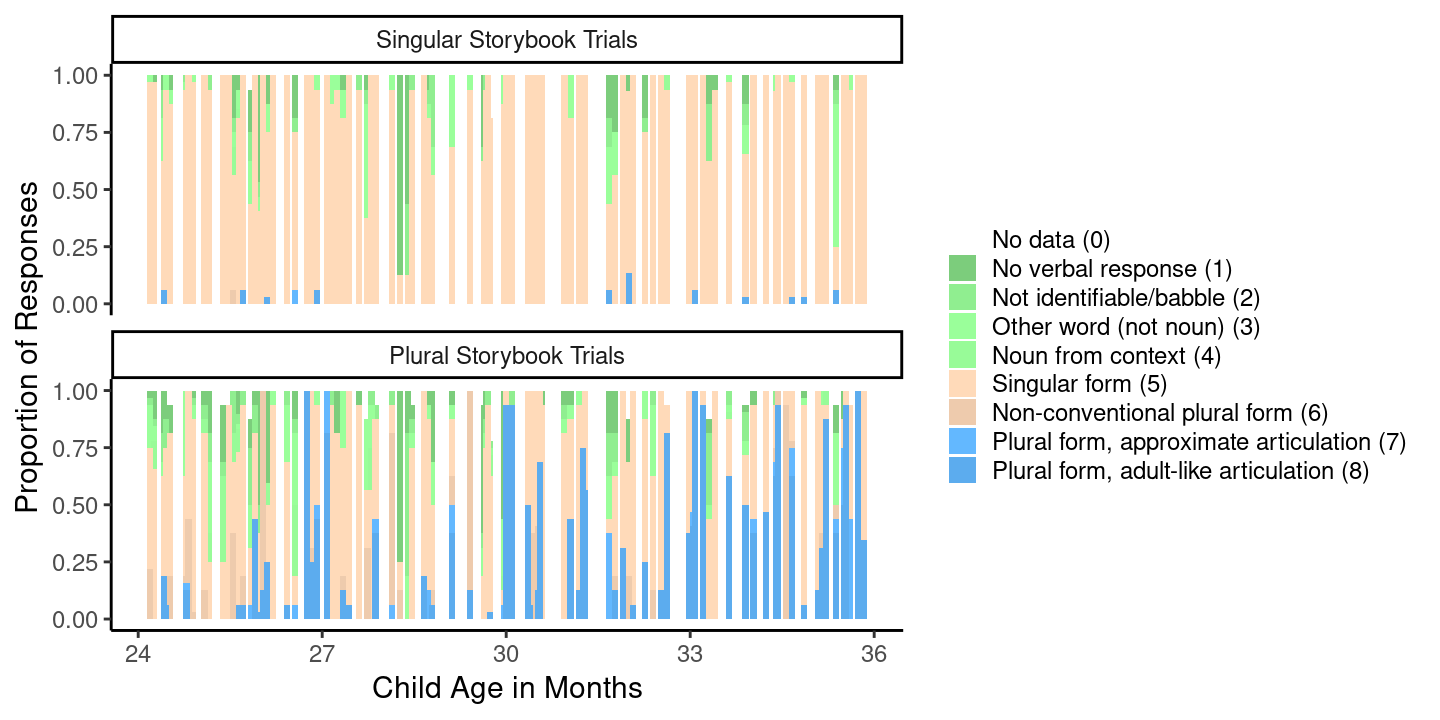

In [67]:
# this is superseded below by collapsing across kids within each age range
options(repr.plot.width=12, repr.plot.height=6)
ggplot(children_in_age_range) + geom_bar(
aes(x=age_in_months, y=count, fill=description),
stat="identity",  width = 0.1, position="fill"
) + scale_fill_manual(values = rep(c("white", "palegreen3", "palegreen2", "palegreen1",
"palegreen", "peachpuff1", "peachpuff2", "steelblue1","steelblue2"), 2)) + facet_wrap(~s_pl_title, ncol=1
) + xlab('Child Age in Months') + ylab('Proportion of Responses') + theme_classic(base_size=18) +theme(legend.title=element_blank())
ggsave('figures/each_child_storybook.pdf', height=6, width=12)

In [68]:
# simplify the coloration of the above
children_in_age_range$recode =
sapply(children_in_age_range$code, function(x){remap[[as.character(x)]]})
children_in_age_range$recode = factor(children_in_age_range$recode,
    levels = c('No Data', 'No Response / Not Relevant', 'Singular',
               'Non-Conventional Plural','Plural'))

In [69]:
subject_info$age_group = sapply(subject_info$age_in_months,
    function(x){
        if (is.na(x)){
            return('No age')
        } else {
            if (x < 28){
                return('24-28')
            } else if (x < 32){
                return('28-32')
            } else {
                return('32-36')
            }
        }
    })

In [70]:
p_coded_aug = merge(p_coded, subject_info[,c('id','age_group')], by.x='child', by.y='id')

In [71]:
p_coded_aug$singular_recode =
sapply(p_coded_aug$Singular.Code, function(x){remap[[as.character(x)]]})
p_coded_aug$singular_recode = factor(p_coded_aug$singular_recode,
    levels = c('No Data', 'No Response / Not Relevant', 'Singular',
               'Non-Conventional Plural','Plural'))

p_coded_aug$plural_recode =
sapply(p_coded_aug$Plural.Code, function(x){remap[[as.character(x)]]})
p_coded_aug$plural_recode = factor(p_coded_aug$plural_recode,
    levels = c('No Data', 'No Response / Not Relevant', 'Singular',
               'Non-Conventional Plural','Plural'))

In [72]:
p_coded_test = merge(p_coded_aug, subject_info[,c('participant_name','expt_version')], by.x='child',by.y="participant_name")
nrow(p_coded_test)
p_coded_aug = p_coded_test

[1] 2304

In [73]:
p_coded_aug = subset(p_coded_aug, expt_version != 'agreement-lookit')

In [74]:
sing_counts = aggregate(itemId ~ singular_recode + novelty + age_group, p_coded_aug, length)
names(sing_counts)[1] = 'code'
names(sing_counts)[length(names(sing_counts))] = 'count'
sing_counts$s_pl = 'Singular Trials'
pl_counts = aggregate(itemId ~ plural_recode + novelty  + age_group, p_coded_aug, length)
names(pl_counts)[1] = 'code'
names(pl_counts)[length(names(pl_counts))] = 'count'
pl_counts$s_pl = 'Plural Trials'
code_counts = rbind(sing_counts,pl_counts)
code_counts$novelty = as.character(code_counts$novelty)
code_counts$novelty[code_counts$novelty == 'familiar'] = 'Familiar Object Words'
code_counts$novelty[code_counts$novelty == 'novel'] = 'Novel Object Words'
head(code_counts)

,code,novelty,age_group,count,s_pl
,<fct>,<chr>,<chr>,<int>,<chr>
1,No Data,Familiar Object Words,24-28,2,Singular Trials
2,No Response / Not Relevant,Familiar Object Words,24-28,50,Singular Trials
3,Singular,Familiar Object Words,24-28,311,Singular Trials
4,Non-Conventional Plural,Familiar Object Words,24-28,1,Singular Trials
5,Plural,Familiar Object Words,24-28,4,Singular Trials
6,No Response / Not Relevant,Novel Object Words,24-28,72,Singular Trials


In [75]:
#child count also
child_sing_counts = aggregate(child ~ singular_recode + novelty + age_group, p_coded_aug, 
    function(x){length(unique(x))})
names(child_sing_counts)[1] = 'code'
names(child_sing_counts)[length(names(child_sing_counts))] = 'child_count'
child_sing_counts$s_pl = 'Singular Trials'
child_pl_counts = aggregate(child ~ plural_recode + novelty + age_group, p_coded_aug, 
    function(x){length(unique(x))})
names(child_pl_counts)[1] = 'code'
names(child_pl_counts)[length(names(child_pl_counts))] = 'child_count'
child_pl_counts$s_pl = 'Plural Trials'
child_code_counts = rbind(child_sing_counts,child_pl_counts)
child_code_counts$novelty = as.character(child_code_counts$novelty)
child_code_counts$novelty[child_code_counts$novelty == 'familiar'] = 'Familiar Object Words'
child_code_counts$novelty[child_code_counts$novelty == 'novel'] = 'Novel Object Words'
head(child_code_counts)


,code,novelty,age_group,child_count,s_pl
,<fct>,<chr>,<chr>,<int>,<chr>
1,No Data,Familiar Object Words,24-28,2,Singular Trials
2,No Response / Not Relevant,Familiar Object Words,24-28,17,Singular Trials
3,Singular,Familiar Object Words,24-28,43,Singular Trials
4,Non-Conventional Plural,Familiar Object Words,24-28,1,Singular Trials
5,Plural,Familiar Object Words,24-28,4,Singular Trials
6,No Response / Not Relevant,Novel Object Words,24-28,23,Singular Trials


In [76]:
both_code_counts = merge(code_counts, child_code_counts, all=T)
both_code_counts[is.na(both_code_counts)] = 0
both_code_counts$label = paste0(both_code_counts$count,' (',both_code_counts$child_count,')')
head(both_code_counts)

,code,novelty,age_group,s_pl,count,child_count,label
,<fct>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
1,No Data,Familiar Object Words,24-28,Plural Trials,4,4,4 (4)
2,No Data,Familiar Object Words,24-28,Singular Trials,2,2,2 (2)
3,No Data,Familiar Object Words,28-32,Plural Trials,6,2,6 (2)
4,No Data,Familiar Object Words,28-32,Singular Trials,5,2,5 (2)
5,No Data,Familiar Object Words,32-36,Plural Trials,5,5,5 (5)
6,No Data,Familiar Object Words,32-36,Singular Trials,1,1,1 (1)


In [77]:
# total child counts per time interval
interval_child_counts = aggregate(child ~ novelty  + age_group, p_coded_aug, 
    function(x){length(unique(x))})
interval_child_counts = rbind(interval_child_counts, interval_child_counts)
interval_child_counts$s_pl = c(rep('Plural Trials', 6), rep('Singular Trials', 6)) 
names(interval_child_counts)[names(interval_child_counts) == 'child'] = 'children_per_interval'
interval_child_counts$novelty = as.character(interval_child_counts$novelty)
interval_child_counts$novelty[interval_child_counts$novelty == 'familiar'] = 'Familiar Object Words'
interval_child_counts$novelty[interval_child_counts$novelty == 'novel'] = 'Novel Object Words'
interval_child_counts

novelty,age_group,children_per_interval,s_pl
<chr>,<chr>,<int>,<chr>
Familiar Object Words,24-28,46,Plural Trials
Novel Object Words,24-28,46,Plural Trials
Familiar Object Words,28-32,34,Plural Trials
Novel Object Words,28-32,34,Plural Trials
Familiar Object Words,32-36,41,Plural Trials
Novel Object Words,32-36,41,Plural Trials
Familiar Object Words,24-28,46,Singular Trials
Novel Object Words,24-28,46,Singular Trials
Familiar Object Words,28-32,34,Singular Trials


In [78]:
both_code_counts = merge(both_code_counts, interval_child_counts)

In [79]:
both_code_counts$age_group_label = paste0(both_code_counts$age_group, '\n(n = ',
    both_code_counts$children_per_interval,')')

In [80]:
# recompute these as proportions
non_missing_code_counts = subset(both_code_counts, code != 'No Data')

code_props = do.call('rbind', lapply(split(non_missing_code_counts, list(non_missing_code_counts$novelty,
    non_missing_code_counts$age_group, non_missing_code_counts$s_pl)), function(df){
    total = sum(df$count)
    df$prop = df$count / total
    return(df)
}))
subset(code_props, s_pl == 'Plural Trials' & novelty == 'Novel Object Words' & age_group == '24-28')

,novelty,age_group,s_pl,code,count,child_count,label,children_per_interval,age_group_label,prop
,<chr>,<chr>,<chr>,<fct>,<int>,<int>,<chr>,<int>,<chr>,<dbl>
Novel Object Words.24-28.Plural Trials.29,Novel Object Words,24-28,Plural Trials,Plural,34,9,34 (9),46,24-28 (n = 46),0.09392265
Novel Object Words.24-28.Plural Trials.30,Novel Object Words,24-28,Plural Trials,Singular,180,38,180 (38),46,24-28 (n = 46),0.49723757
Novel Object Words.24-28.Plural Trials.31,Novel Object Words,24-28,Plural Trials,Non-Conventional Plural,21,7,21 (7),46,24-28 (n = 46),0.05801105
Novel Object Words.24-28.Plural Trials.33,Novel Object Words,24-28,Plural Trials,No Response / Not Relevant,127,35,127 (35),46,24-28 (n = 46),0.35082873


Warning message in geom_bar(aes(x = age_group_label, y = prop, fill = code, label = count), :
“Ignoring unknown aesthetics: label”
Warning message in geom_text(size = 3, aes(x = age_group_label, y = prop, fill = code, :
“Ignoring unknown aesthetics: fill”


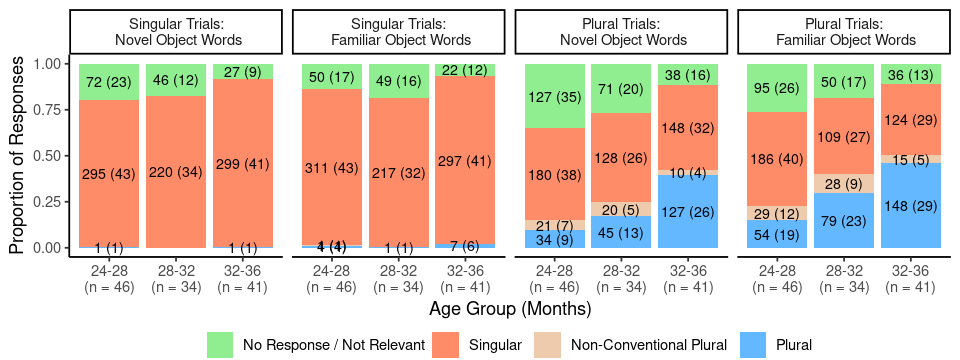

In [81]:
code_props$s_pl_by_novelty = paste0(code_props$s_pl,":\n ", code_props$novelty)
code_props$s_pl_by_novelty = factor(code_props$s_pl_by_novelty)
code_props$s_pl_by_novelty = factor(code_props$s_pl_by_novelty, levels = rev(levels(code_props$s_pl_by_novelty)))

options(repr.plot.width=8, repr.plot.height=3)
ggplot(code_props) + geom_bar(
aes(x=age_group_label, y=prop, fill=code, label=count),
stat="identity", position="stack"
) + facet_wrap(~s_pl_by_novelty, nrow=1) + xlab('Age Group (Months)') + ylab('Proportion of Responses'
) + theme_classic() + scale_fill_manual(values = rep(c("palegreen2", 
 "salmon1", "peachpuff2","steelblue1"), 2)
) + geom_text(size=3, aes(x=age_group_label, y=prop, fill=code, label=label),
          position = position_stack(vjust = 0.5)) + theme(legend.position="bottom",
    legend.title = element_blank(), legend.direction='vertical', legend.margin=margin(0,0,0,0),
        legend.box.margin=margin(-10,-5,-5,-5)) + guides(fill=guide_legend(ncol=4))
ggsave('figures/production_props.pdf', height=2.5, width=8)

In [82]:
p_coded_incl = subset(p_coded, child %in% subset(subject_info, child_in_study)$participant_name)
p_coded_incl = merge(p_coded_incl, subject_info[,c('participant_name','expt_version')], by.x='child',by.y="participant_name")
p_coded_incl = subset(p_coded_incl, expt_version != 'agreement-lookit')
names(p_coded_incl)

[1] "child"                     "Lemma"                    
 [3] "itemId"                    "Singular.description"     
 [5] "Singular.Code"             "Plural.Description"       
 [7] "Plural.Code"               "Comments"                 
 [9] "X"                         "novel_id"                 
[11] "background_context"        "vowel_carrier"            
[13] "full_carrier"              "s_carrier"                
[15] "s_punct"                   "s_wav_index"              
[17] "s_sentence"                "pl_form"                  
[19] "pl_carrier"                "pl_punct"                 
[21] "pl_wav_index"              "pl_sentence"              
[23] "novelty"                   "voicing"                  
[25] "simple_pl_stim"            "simple_s_stim"            
[27] "animacyStatus"             "test_index"               
[29] "trial_index"               "Trial"                    
[31] "Practice"                  "NovelColor"               
[33] "book"                      "Singular.Code.Downsampled"
[35] "Plural.Code.Downsampled"   "age_in_months"            
[37] "include_storybook"         "s_success"                
[39] "pl_success"                "age_in_months_c"          
[41] "expt_version"

In [83]:
nProducingAPlural = length(unique(subset(p_coded_incl, Plural.Code %in% c(7,8))$child))
nProducingAPlural
tvc = update_texvar_cache(tvc, 'nProducingAPlural', nProducingAPlural)

[1] 73

In [84]:
# Number of participants with production data
storybookNwithProductions = length(unique(p_coded_incl$child))
storybookNwithProductions
tvc = update_texvar_cache(tvc, 'storybookNwithProductions', storybookNwithProductions)

[1] 118

In [85]:
# Number that produced one or more novel plurals
nProducingNovelPlurals = length(unique(subset(p_coded_incl, Plural.Code %in% c(7,8) & novelty == 'novel' )$child))
tvc = update_texvar_cache(tvc, 'nProducingNovelPlurals', nProducingNovelPlurals)
nProducingNovelPlurals

[1] 48

In [86]:
# Number that produced one or more novel singulars
nNovelSingulars = length(unique(subset(p_coded_incl, Singular.Code %in% c(5) & novelty == 'novel' )$child))
tvc = update_texvar_cache(tvc, 'nNovelSingulars', nNovelSingulars)
nNovelSingulars

[1] 116

In [87]:
# Number that produced non-conventional plurals
nNonconventionalPlurals = length(unique(subset(p_coded_incl, Plural.Code %in% c(6) & novelty == 'novel' )$child))
tvc = update_texvar_cache(tvc, 'nNonconventionalPlurals', nNonconventionalPlurals)
nNonconventionalPlurals

[1] 16

# Familiar vs. Novel Plurals

In [88]:
kids_with_production_data = data.frame(child= unique(p_coded_incl$child))

In [89]:
fam = aggregate(Plural.Code ~ child, subset(p_coded_incl, Plural.Code %in% c(7,8) & novelty == 'familiar'),
          length)
fam = merge(kids_with_production_data, fam, all = T)
fam[is.na(fam)] = 0
names(fam) = c('child','fam_pl')

nov = aggregate(Plural.Code ~ child, subset(p_coded_incl, Plural.Code %in% c(7,8) & novelty == 'novel'),
          length)
nov = merge(kids_with_production_data, nov, all =T)
nov[is.na(nov)] = 0
names(nov) = c('child','nov_pl')


combined = merge(fam, nov, all=T)
combined[is.na(combined)] = 0
combined = merge(combined, subject_info[,c('participant_name','age_in_months','age_group')],
     by.x='child', by.y='participant_name')
nrow(combined)


[1] 118

In [90]:
lm_eqn(subset(combined, fam_pl > 0 | nov_pl > 0), 'nov_pl ~ fam_pl')

[1] "~~italic(R)^2 ~ \"=\" ~ \"0.696\" * \",\" ~ ~italic(p) ~ \"=\" ~ \"4.68e-20\""

Warning message in geom_abline(yintercept = 0, slope = 1, linetype = "dashed", alpha = 0.5):
“Ignoring unknown parameters: `yintercept`”
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


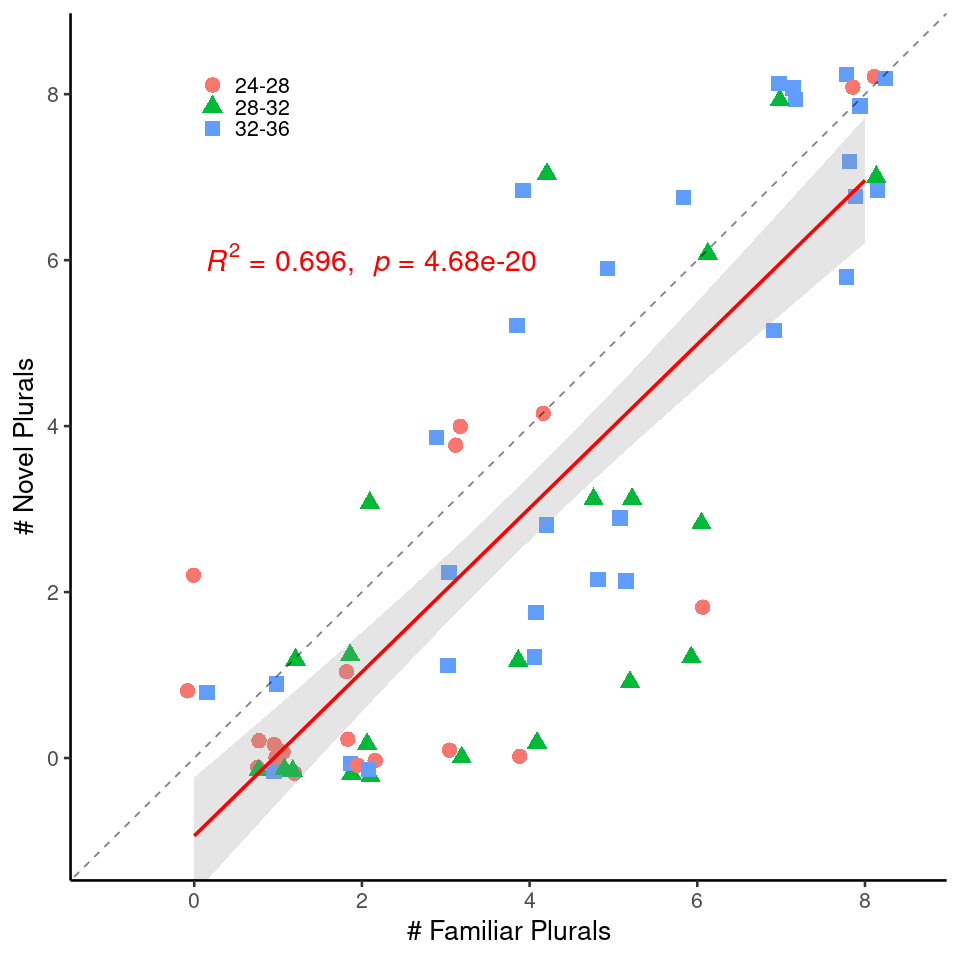

In [91]:

options(repr.plot.width=8, repr.plot.height=8)
ggplot(subset(combined, fam_pl > 0 | nov_pl > 0)) + geom_jitter(aes(x=fam_pl, y=nov_pl, color=factor(age_group), shape=factor(age_group)
), width=.25, height=.25, size=4) + theme_classic(base_size=16
) + xlab('# Familiar Plurals') + ylab('# Novel Plurals') + coord_cartesian(xlim=c(-1,8.5),
    ylim=c(-1,8.5)) + geom_abline(yintercept=0, slope=1, linetype = 'dashed', alpha=.5
) + theme(
    legend.key.size = unit(.4, "cm"),
    legend.position = c(.2,.9), 
    legend.background = element_rect(fill="white", linetype="solid", 
                                  colour ="white"),
    legend.title=element_blank()
) + annotate("text", x = 2, y = 6,
    label = lm_eqn(subset(combined, fam_pl > 0 | nov_pl > 0), 'nov_pl ~ fam_pl'), parse=T, size = 6, color='red'
) + geom_smooth(aes(x=fam_pl, y=nov_pl), method='lm',
    color='red', alpha=.25)
ggsave('figures/familiar_vs_novel_plurals.pdf', width = 6, height=6)

In [92]:
combined_counts = aggregate(child ~ nov_pl + fam_pl, subset(combined, fam_pl > 0 | nov_pl > 0), length)
names(combined_counts)

[1] "nov_pl" "fam_pl" "child"

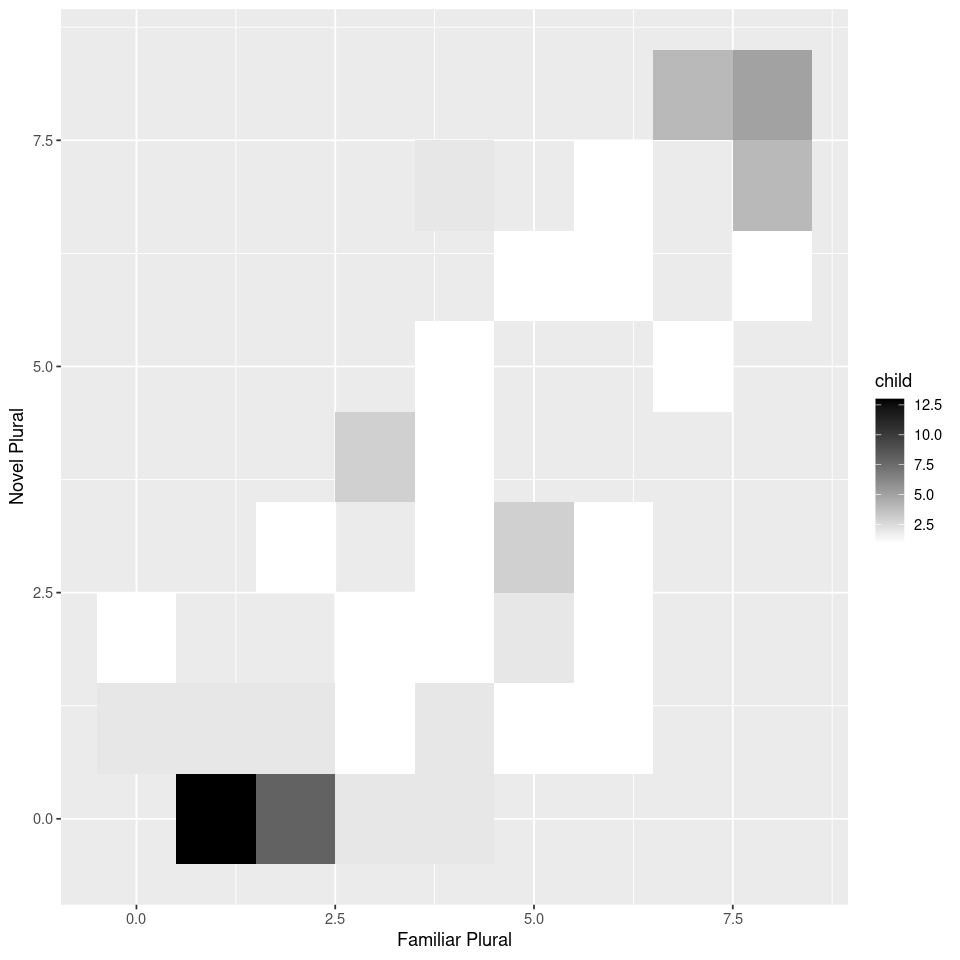

In [93]:
ggplot(subset(combined_counts, nov_pl > 0 | fam_pl > 0)) + geom_tile(aes(fam_pl, nov_pl, fill=child)) +
  scale_fill_gradient(low = "white", high = "black") + xlab('Familiar Plural') + ylab('Novel Plural')

In [94]:
numChildrenWithSingPl = nrow(combined)
tvc = update_texvar_cache(tvc, 'numChildrenWithSingPl', numChildrenWithSingPl)

In [95]:
fam_nov_cor = cor.test(combined$fam_pl, combined$nov_pl, method='spearman')
fam_nov_cor

Warning message in cor.test.default(combined$fam_pl, combined$nov_pl, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  combined$fam_pl and combined$nov_pl
S = 49994, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8174198 


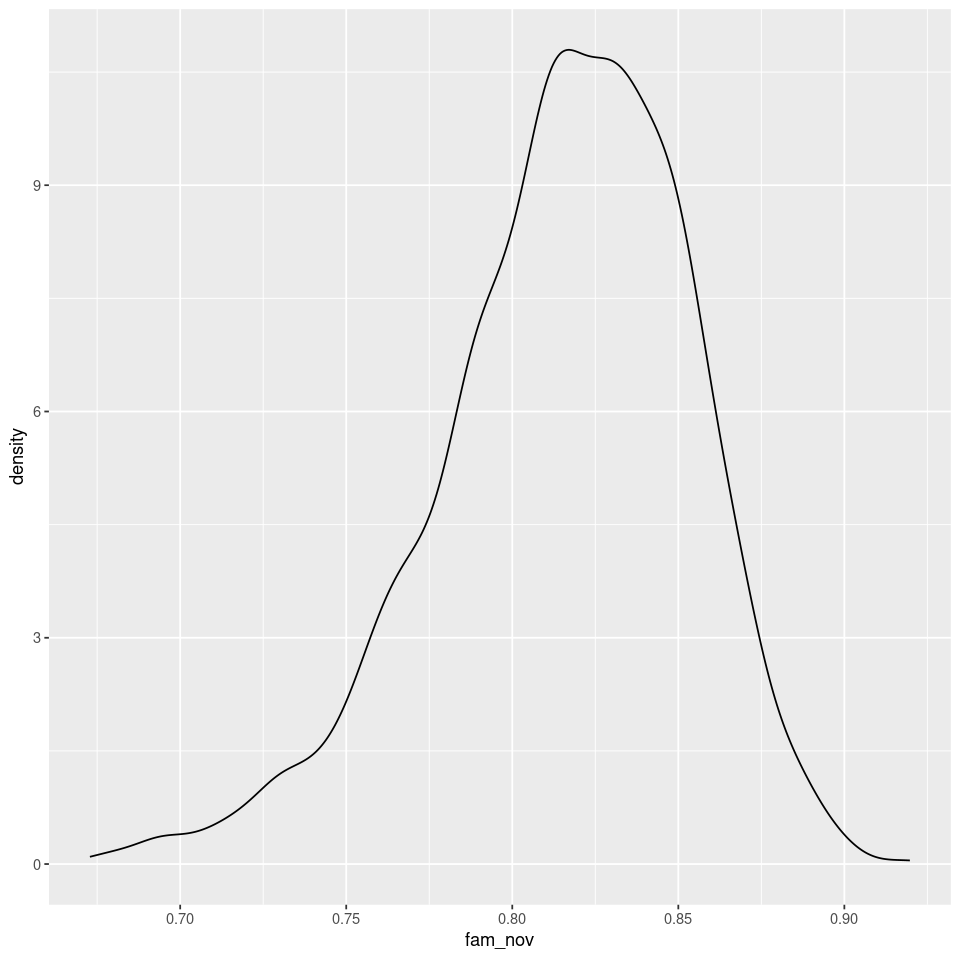

In [96]:
fam_nov = spearboot(combined, 'fam_pl', 'nov_pl', cor_method='spearman' )
ggplot(data.frame(fam_nov= t(fam_nov))) + geom_density(aes(x=fam_nov))

In [97]:
fam_nov_cor_boot_ci = quantile(t(fam_nov), c(0.025, 0.975))
fam_nov_cor_boot_ci[['2.5%']]
fam_nov_cor_boot_ci[['97.5%']]

[1] 0.7286234

[1] 0.8788399

In [98]:
tvc = update_texvar_cache(tvc, 'famNovCor', fam_nov_cor$estimate, digits=3)
tvc = update_texvar_cache(tvc, 'famNovCorP', fam_nov_cor$p.value, digits=3)
tvc = update_texvar_cache(tvc, 'famNovCorUpper', fam_nov_cor_boot_ci[['97.5%']], digits=3)
tvc = update_texvar_cache(tvc, 'famNovCorLower', fam_nov_cor_boot_ci[['2.5%']], digits=3)

In [99]:
numProducingHalfNovelPlurals = nrow(subset(nov, nov_pl >= 4))
tvc = update_texvar_cache(tvc, 'numProducingHalfNovelPlurals', numProducingHalfNovelPlurals)
numProducingHalfFamiliarPlurals= nrow(subset(fam, fam_pl>= 4))
tvc = update_texvar_cache(tvc, 'numProducingHalfFamiliarPlurals', numProducingHalfFamiliarPlurals)
combined$total_pl = combined$nov_pl + combined$fam_pl

In [100]:
nrow(subset(combined, nov_pl > 0)) / nrow(combined)


[1] 0.4067797

In [101]:
names(combined)

[1] "child"         "fam_pl"        "nov_pl"        "age_in_months"
[5] "age_group"     "total_pl"

In [102]:
subject_info_with_pl_scores = merge(subject_info_with_broad_scores, 
                                   combined[,c('child','fam_pl', 'nov_pl','total_pl')],
                                            by.x='participant_name',
                                            by.y="child",
                                   all.x=T, all.y=T)
subject_info_with_pl_scores = subset(subject_info_with_pl_scores, !is.na(id))

# Write out TexVars

In [103]:
writeout_texvar_cache(tvc, 'texvars/plearn_analysis_02.tex',appendDate=T)

# Save the R objects for loading in the other notebooks

In [104]:
saveRDS(subject_info_with_pl_scores, file='intermediate_data/subject_info.RData')